In [51]:
import argparse
import logging
import re

import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.options.pipeline_options import StandardOptions
from apache_beam.options.pipeline_options import SetupOptions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Prerequisites prior to running demo:
1) Billing-enabled project
2) API's enabled and necessary IAM role(s) for necessary services (e.g. Dataflow, BigQuery)
3) GCS bucket for temporary and schema files
4) BigQuery dataset (tables can / will be created if they don't already exist)
5) Pub/Sub topic for streaming data

In [52]:
files = ['gs://mg-ce-demos/iot/data/unitedrental_message_raw_20221101.csv']
local_file = 'data/iot_data_unitedrental_message_raw_20221101.csv'

# Dataflow Batch - GCS Text Files to BQ

In [53]:
class DataIngestion:
    """A helper class which contains the logic to translate the file into
    a format BigQuery will accept."""

    def parse_method(self, string_input):
        """This method translates a single line of comma separated values to a
        dictionary which can be loaded into BigQuery."""
        # Strip out carriage return, newline and quote characters.
        values = re.split(",", re.sub('\r\n', '', re.sub('"', '',string_input)))
        split_values = []
        keys = []
        main_values = []
        field_values = []
        
        for value in values:
            index = value.find('=')

            if index != -1:
                split_values.append(value[index+1:])
                keys.append(value[:index])
            else:
                split_values.append(value)
                
        main_values.extend(split_values[:5])
        field_values.extend(split_values[5:10])

        row_main = dict(zip(('site_id','created_date','actual_date','unprocessed_guid','imei'), main_values))
        row_fields = dict(zip(('IMEI_raw','ActualDate','HardwareName','UnprocessedCreated','ServerName',), field_values))
        
        counter = 0
        for i in range(0,750):
            if str(i) in keys:
                key = 'field_' + str(i)
                row_fields[key] = split_values[10+counter]
                counter += 1
            else:
                key = 'field_' + str(i)
                row_fields[key] = ''
                

        #row_fields = dict(zip(('field_2','field_3','field_4','field_5','field_6','field_7','field_9','field_10','field_11','field_12','field_13','field_14','field_15','field_101','field_102','field_111','field_112','field_113','field_117','field_133','field_134','field_201','field_225','field_315','field_511','field_550','field_551','field_552', 'field_601'), field_values_2))
        row = row_main | row_fields
        #row = dict(zip(('site_id','created_date','actual_date','unprocessed_guid','imei','raw_message'), final_values))
        return row
    
    
    

In [54]:
#test_string = '1628,2022-11-01 00:00:26,2022-10-31 23:58:14,e8c9c5f5-7e88-4a4d-aafe-6adb9db265e3,0470000612,"IMEI=0470000612,ActualDate=10/31/2022 23:58:14,HardwareName=SUNTECHST4340,UnprocessedCreated=11/01/2022 00:00:26,ServerName=PL-LISTEN-ATL3,2=ALT,3=A,4=True,5=39.772027,6=-104.857099,7=0,9=0,10=100,11=20,12=00000001,13=00000000,14=4.1,101=ALT,102=ALT33,111=0,112=0,113=0,117=33,133=2,134=21.3827777777778,201=366.443,225=10.83,315=ALT,511=CellID:97594895|LAC:38406|MCC:310|MNC:410,550=1.0.6,551=47,552=1"'


In [55]:
#data_ingestion = DataIngestion()
#data_ingestion.parse_method(test_string)


In [56]:
def run(argv=None):
    """The main function which creates the pipeline and runs it."""
    
    schema_1 = 'site_id:STRING,created_date:DATETIME,actual_date:DATETIME,unprocessed_guid:STRING,imei:STRING,IMEI_raw:STRING,ActualDate:STRING,HardwareName:STRING,UnprocessedCreated:STRING,ServerName:STRING'
    schema_2 = ''
    for i in range(0,750):
        field = ',field_' + str(i) + ':STRING'
        schema_2 += field
    SCHEMA = schema_1 + schema_2

    parser = argparse.ArgumentParser()

    # Here we add some specific command line arguments we expect.
    # Specifically we have the input file to read and the output table to write.
    # This is the final stage of the pipeline, where we define the destination
    # of the data. In this case we are writing to BigQuery.
    parser = argparse.ArgumentParser()
    parser.add_argument('--runner', required=False, default='DirectRunner', help='DataflowRunner or DirectRunner (local)')
    parser.add_argument('--job_name', required=False, default='iot-data-demo', help='Dataflow Job Name')
    parser.add_argument('--project_id', required=False, default='mg-ce-demos', help='GCP Project ID')
    parser.add_argument('--region', required=False, default='us-central1', help='GCP region for execution')
    parser.add_argument('--dataset_name', required=False, default='iot_data', help='Output BigQuery Dataset') 
    parser.add_argument('--table_name', required=False, default='iot_data_raw', help='Output BigQuery Table')
    parser.add_argument('--input_data', required=False, default='gs://mg-ce-demos/iot/data/unitedrental_message_raw_20221101.csv', help='input data (for batch only')
    parser.add_argument('--subnetwork', required=False, default='https://www.googleapis.com/compute/v1/projects/mg-ce-demos/regions/us-central1/subnetworks/mg-ce-demos', help='define subnetwork')

    
    known_args, pipeline_args = parser.parse_known_args(argv)
    
    pipeline_args.extend([
          '--runner=' + str(known_args.runner) # Change this to DataflowRunner to run your pipeline on the Google Cloud Dataflow Service.
          ,'--project=' + str(known_args.project_id) # Your project ID is required in order to run your pipeline on the Google Cloud Dataflow Service.
          ,'--staging_location=gs://mg-ce-demos/iot/temp' # Your Google Cloud Storage path is required for staging local files.
          ,'--temp_location=gs://mg-ce-demos/iot/tmp' # Your Google Cloud Storage path is required for temporary files.
          ,'--job_name=' + str(known_args.job_name) # Set project unique job name
          ,'--region=' + str(known_args.region) # Set region if using DataflowRunner
          #,'--subnetwork=' + str(known_args.subnetwork) # Set if using DataflowRunner
      ])
    
    # DataIngestion is a class we built in this script to hold the logic for
    # transforming the file into a BigQuery table.
    data_ingestion = DataIngestion()
    
    pipeline_options = PipelineOptions(pipeline_args)
    #pipeline_options.view_as(SetupOptions).save_main_session = True
    #pipeline_options.view_as(StandardOptions).streaming = True  # set to True if stream (remove if batch)
    
    with beam.Pipeline(options=pipeline_options) as p:
        # Read the file. This is the source of the pipeline. All further
        # processing starts with lines read from the file. We use the input
        # argument from the command line. We also skip the first line which is a
        # header row.
        events = (p | beam.io.ReadFromText(known_args.input_data, skip_header_lines=1))\
        
        # Tranform events to fit in BQ schema
        transformed = (events | beam.Map(lambda s: data_ingestion.parse_method(s)))
        
        # Persist to BigQuery
        transformed | 'Write' >> beam.io.WriteToBigQuery(
                            table=known_args.table_name,
                            dataset=known_args.dataset_name,
                            project=known_args.project_id,
                            schema=SCHEMA,
                            create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,
                            write_disposition=beam.io.BigQueryDisposition.WRITE_TRUNCATE
                            )
        p.run().wait_until_finish()  ## remove if dataflow


In [57]:
%%time

if __name__ == '__main__':
    logging.getLogger().setLevel(logging.INFO)
    run()

INFO:root:Default Python SDK image for environment is apache/beam_python3.9_sdk:2.43.0
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function annotate_downstream_side_inputs at 0x7fdc5293c8b0> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function fix_side_input_pcoll_coders at 0x7fdc5293c9d0> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function pack_combiners at 0x7fdc5293cee0> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function lift_combiners at 0x7fdc5293cf70> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function expand_sdf at 0x7fdc5293d160> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function expand_gbk at 0x7fdc5293d1f0> ============

CPU times: user 3min 3s, sys: 13.3 s, total: 3min 16s
Wall time: 7min 48s


# Data Analysis

In [58]:
from google.cloud import bigquery


In [59]:
bq = bigquery.Client(project = 'mg-ce-demos')

# get schema from bigquery source
query = f"SELECT * FROM mg-ce-demos.iot_data.iot_data_raw"
df_raw = bq.query(query).to_dataframe()
#df_raw.head()

In [60]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90125 entries, 0 to 90124
Columns: 760 entries, site_id to field_749
dtypes: datetime64[ns](2), object(758)
memory usage: 522.6+ MB


In [61]:
nan_value = float("NaN")
df = df_raw.replace("", nan_value)
df = df[df.columns[~df.isnull().all()]]


In [62]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# sum of null values by column
df.isnull().sum(axis=0).sort_values(ascending=False)

field_1               90117
field_601             90096
field_114             89273
field_246             89273
field_508             89269
field_134             89081
field_201             89073
field_14              88229
field_117             87932
field_103             79240
field_118             77301
field_552             75108
field_550             75108
field_112             74256
field_113             74256
field_11              64216
field_111             63371
field_10              52158
field_313             41192
field_13              38193
field_700             30804
field_8               30768
field_241             30384
field_12              27307
field_225             27065
field_558             26740
field_701             19452
field_224             18087
field_6               15779
field_5               15779
field_9               15751
field_7               15751
field_102             15585
field_551             11723
field_315             10893
field_15            

In [63]:
df_sub = df[df.columns.difference(['field_1', 'field_10','field_11','field_14', 'field_103', 'field_111', 'field_112', 'field_113', 'field_114', 'field_117', 'field_118', 'field_134', 'field_201', 'field_246', 'field_508', 'field_550', 'field_552', 'field_601'])]
#df_sub.head()

In [64]:
# creating home favorite and away favorite columns (fill na with 0's)
df_sub.loc[df_sub.field_4 == 'True', 'field_4'] = 1
df_sub.loc[df_sub.field_4 == 'False', 'field_4'] = 0
df_sub.fillna(0, inplace=True)


/var/folders/q8/1gf829m141157nbz7kc4_19h00tb0q/T/ipykernel_6979/1802865831.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.fillna(0, inplace=True)


In [65]:
#df_sub.head()

In [66]:
# Using pandas.unique() to unique values in multiple columns
for i in df_sub:
    print(i + str(pd.unique(df_sub[i].values.ravel('K'))))

ActualDate['11/22/2022 22:11:55' '11/22/2022 21:59:48' '11/22/2022 23:00:09' ...
 '11/05/2022 15:29:21' '11/05/2022 15:42:38' '12/02/2022 21:37:45']
HardwareName['QUECLINKGV600MG' 'CouchbaseSync' 'CALAMPLMD' 'SUNTECHST4340'
 'QUECLINKGV350M']
IMEI_raw['860092056319714' '860092055137471' '860092056360585' '860092055205310'
 '860092056374651' '860092059277588' '860092055262188' '4764243034'
 '0470000612' '0470000617' '0470000618' '0470000610' '862599050038056'
 '862599050022852' '862599050043593' '862599050039690' '862599050038890']
ServerName['PL-LISTEN-ATL2' 'PL-LISTEN-ATL3' 'PL-LISTEN-ATL4' 'couchbasesync'
 'PL-LISTEN-ATL6' 'PL-LISTEN-ATL1' 'PL-LISTEN-ATL5']
UnprocessedCreated['11/22/2022 22:11:56' '11/22/2022 21:59:51' '11/22/2022 22:00:10' ...
 '11/16/2022 22:49:17' '11/16/2022 23:14:10' '11/16/2022 23:18:36']
actual_date['2022-11-22T22:11:55.000000000' '2022-11-22T21:59:48.000000000'
 '2022-11-22T23:00:09.000000000' ... '2022-11-05T15:29:21.000000000'
 '2022-11-05T15:42:38.00000000

In [67]:
df_sub = df_sub.astype({"field_15":"int", "field_224":"float", "field_225":"float", "field_241":"float", "field_5":"float", "field_7":"int","field_8":"float", "field_9":"float"})


# Data Visualizations

<AxesSubplot: xlabel='field_4', ylabel='count'>

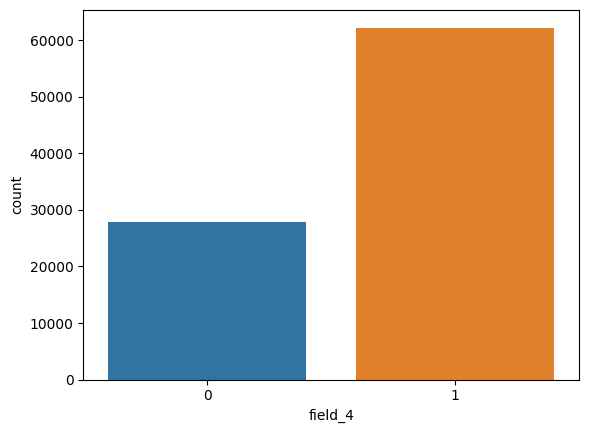

In [68]:
sns.countplot(x="field_4", data=df_sub)

/var/folders/q8/1gf829m141157nbz7kc4_19h00tb0q/T/ipykernel_6979/753996114.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax2 = sns.heatmap(df_sub.corr(),annot=True, vmin=-1,vmax=1,cmap=sns.diverging_palette(h_neg=220,h_pos=10,n=21))


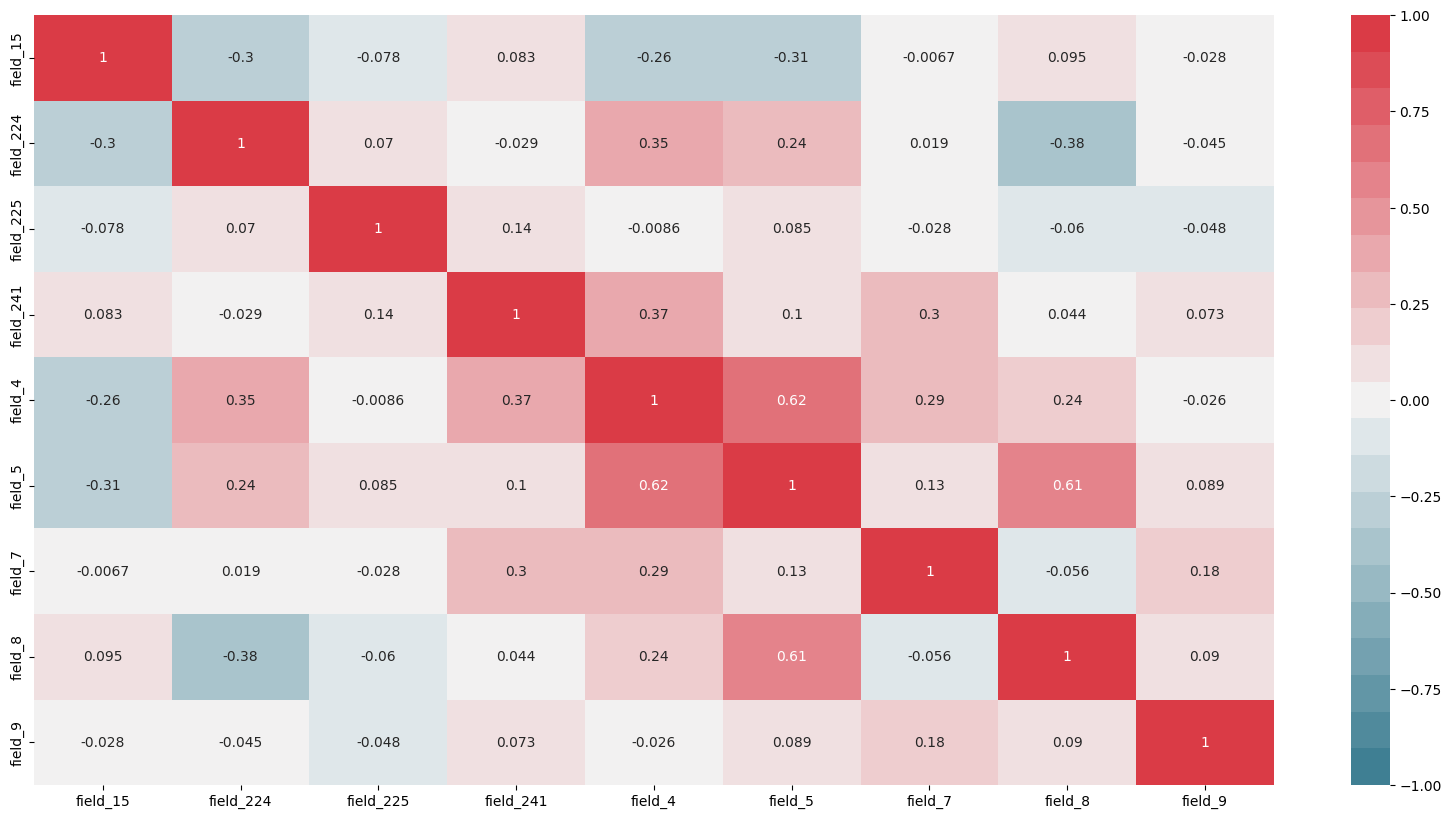

In [71]:
plt.figure(figsize = (20,10))
ax2 = sns.heatmap(df_sub.corr(),annot=True, vmin=-1,vmax=1,cmap=sns.diverging_palette(h_neg=220,h_pos=10,n=21))

# Modeling

In [73]:
# required machine learning packages
from sklearn import model_selection
from sklearn.feature_selection import RFE
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV as CCV
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [79]:
X = df_sub[["field_15", "field_224", "field_225", "field_241", "field_5", "field_7","field_8", "field_9"]]
X.head()

,field_15,field_224,field_225,field_241,field_5,field_7,field_8,field_9
0,21389,0.00,0.00,0.0,0.0,0,0.0,0.0
1,752,0.00,0.00,0.0,0.0,0,0.0,0.0
2,2429,0.00,0.00,0.0,0.0,0,0.0,0.0
3,1009,0.00,0.00,0.0,0.0,0,0.0,0.0
4,0,0.98,11.45,0.0,0.0,0,0.0,0.0


In [80]:
y = df_sub['field_4']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: field_4, dtype: int64

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)

In [83]:
# prepare models
models = []

# Classifiers to use in Voting
boost = xgb.XGBClassifier(eval_metric='logloss')
dtc = DecisionTreeClassifier(max_depth=5, criterion='entropy')
lrg = LogisticRegression(solver='newton-cg')
vote = VotingClassifier(estimators=[('boost', boost), ('dtc', dtc), ('lrg', lrg)], voting='soft')

models.append(('LRG', LogisticRegression(solver='newton-cg')))
models.append(('KNB', KNeighborsClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('XGB', xgb.XGBClassifier(eval_metric='logloss', random_state=0)))
models.append(('RFC', RandomForestClassifier(random_state=0, n_estimators=100)))
models.append(('DTC', DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=5)))
models.append(('SVC', LinearSVC(random_state=0)))
models.append(('VOTE', VotingClassifier(estimators=[('boost', boost), ('dtc', dtc), ('lrg', lrg)], voting='soft')))
models.append(('CCV', CCV(vote, method='isotonic', cv=3)))
models.append(('MLP', MLPClassifier()))
models.append(('ADA', AdaBoostClassifier(random_state=0)))

# evaluate each model by average of roc auc 
results_dict = {}

In [86]:
%%time
for name, m in models:
    kfold = model_selection.KFold(n_splits=5) 
    cv_results = model_selection.cross_val_score(m, X_train, y_train, cv=kfold, scoring = 'roc_auc') # or 'accuracy'
    results_dict.update({name: "%f" % cv_results.mean()})

/Users/mikegoodman/Documents/developer/venv/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/mikegoodman/Documents/developer/venv/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/mikegoodman/Documents/developer/venv/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
/Users/mikegoodman/Documents/developer/venv/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/mikegoodman/Document

CPU times: user 13min 13s, sys: 2min 1s, total: 15min 15s
Wall time: 2min 44s


In [87]:
# results_dict
sorted(((v,k) for k,v in results_dict.items()), reverse=True)

[('0.999937', 'XGB'),
 ('0.999785', 'VOTE'),
 ('0.999778', 'CCV'),
 ('0.999719', 'ADA'),
 ('0.999612', 'RFC'),
 ('0.998038', 'KNB'),
 ('0.994738', 'LRG'),
 ('0.992495', 'DTC'),
 ('0.976405', 'MLP'),
 ('0.942003', 'GNB'),
 ('0.812891', 'SVC')]

In [88]:
# Fit best model to all of training set
vote = VotingClassifier(estimators=[('boost', boost), ('dtc', dtc), ('lrg', lrg)], voting='soft')
model = vote.fit(X_train, y_train)

/Users/mikegoodman/Documents/developer/venv/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


In [89]:
# predict probabilities
predicted = model.predict_proba(X_test)[:,1]

In [90]:
# predict home team win or lose (0/1)
predictions = model.predict(X_test)

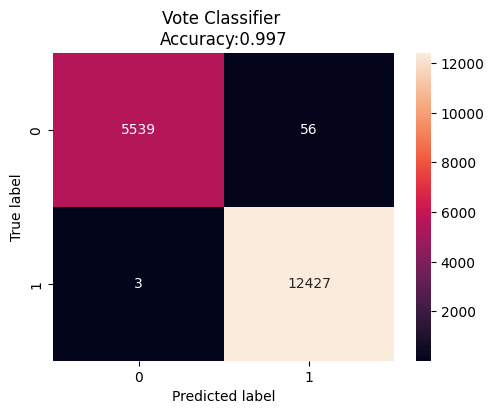

In [93]:
cm = metrics.confusion_matrix(y_test, predictions)

plt.figure(figsize=(5.5,4))
sns.heatmap(cm, annot=True, fmt="g")
plt.title('Vote Classifier \nAccuracy:{0:.3f}'.format(model.score(X_test, y_test)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

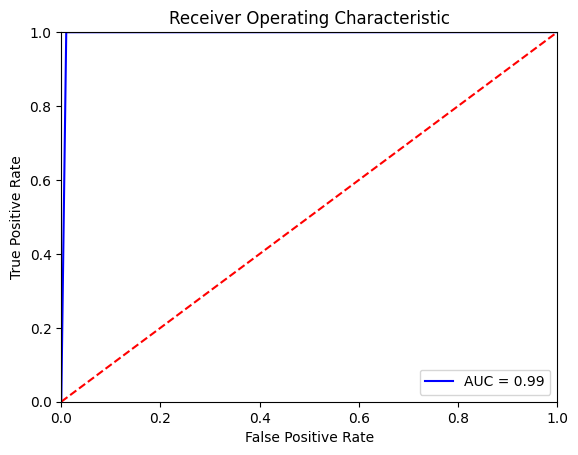

In [94]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()